In [5]:
import os
import datetime
import numpy as np
from tqdm import tqdm
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from explore.datasets.utils import cost_computation, load_trees

dataset_paths = "../multirun/2026-02-17/14-59-02"
ds_c = len(os.listdir(dataset_paths)) - 1

## Cost evolution over nodes

../multirun/2026-02-17/14-59-02/0
Looking at start_idx 1 and end_idx -1 with error threshold 0.05.
Tau action: 0.2; Tau sim: 0.005
Tree Count: 100
Loaded  13195  RRT nodes.


13096it [00:03, 4246.52it/s]


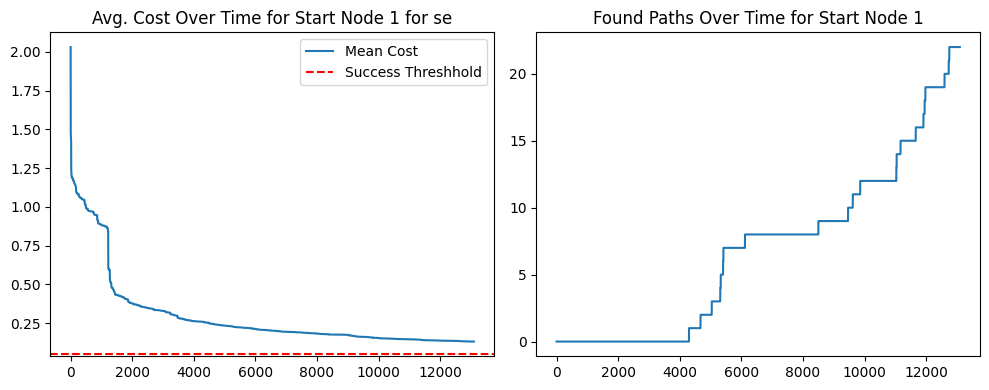

../multirun/2026-02-17/14-59-02/1
Looking at start_idx 2 and end_idx -1 with error threshold 0.05.
Tau action: 0.2; Tau sim: 0.005
Tree Count: 100
Loaded  14667  RRT nodes.


14568it [00:03, 4431.54it/s]


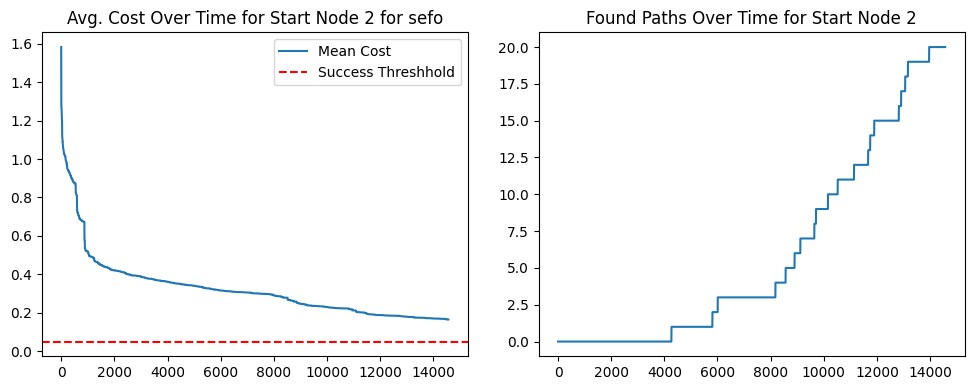

../multirun/2026-02-17/14-59-02/2
Looking at start_idx 3 and end_idx -1 with error threshold 0.05.
Tau action: 0.2; Tau sim: 0.005
Tree Count: 100
Loaded  14407  RRT nodes.


14308it [00:03, 4368.72it/s]


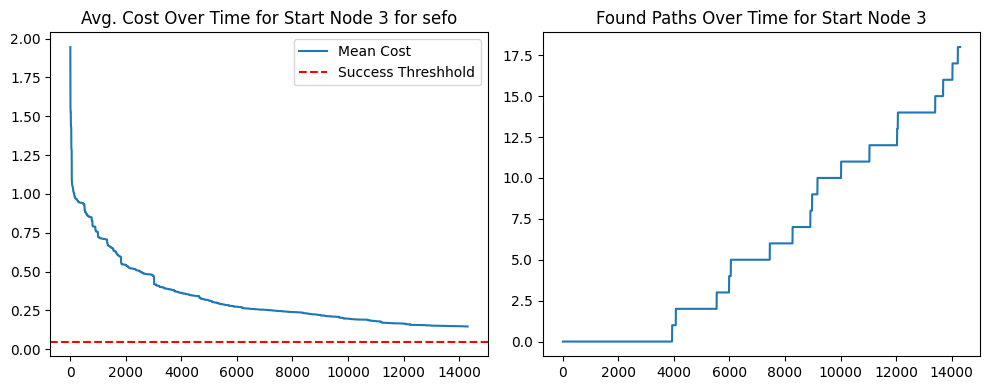

../multirun/2026-02-17/14-59-02/3
Looking at start_idx 4 and end_idx -1 with error threshold 0.05.
Tau action: 0.2; Tau sim: 0.005
Tree Count: 100
Loaded  14229  RRT nodes.


14130it [00:03, 4525.31it/s]


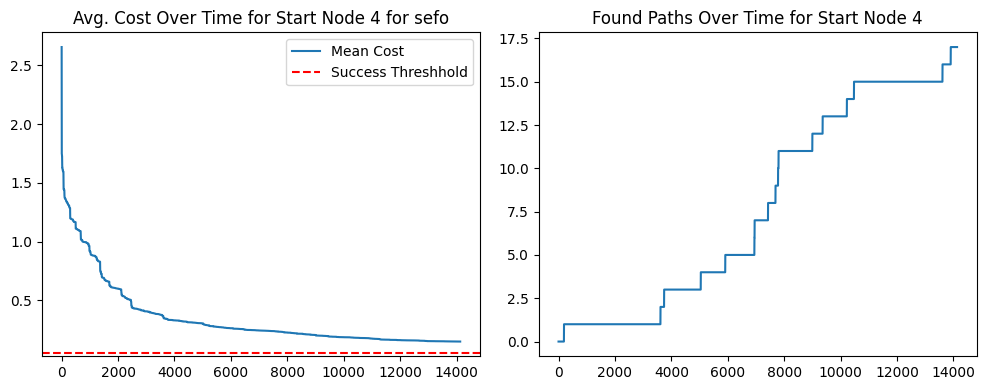

../multirun/2026-02-17/14-59-02/4
Looking at start_idx 5 and end_idx -1 with error threshold 0.05.
Tau action: 0.2; Tau sim: 0.005
Tree Count: 100
Loaded  12908  RRT nodes.


12809it [00:02, 4463.54it/s]


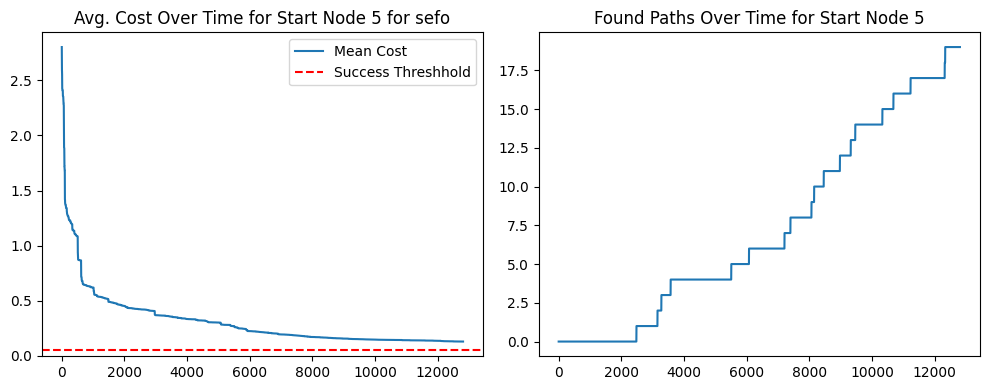

../multirun/2026-02-17/14-59-02/5
Looking at start_idx 6 and end_idx -1 with error threshold 0.05.
Tau action: 0.2; Tau sim: 0.005
Tree Count: 100
Loaded  14330  RRT nodes.


14231it [00:03, 4471.08it/s]


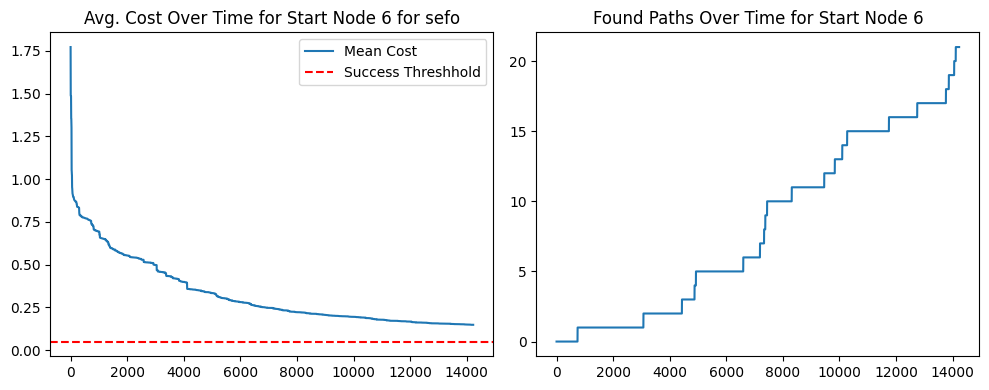

../multirun/2026-02-17/14-59-02/6
Looking at start_idx 7 and end_idx -1 with error threshold 0.05.
Tau action: 0.2; Tau sim: 0.005
Tree Count: 100
Loaded  21651  RRT nodes.


21552it [00:04, 4576.59it/s]


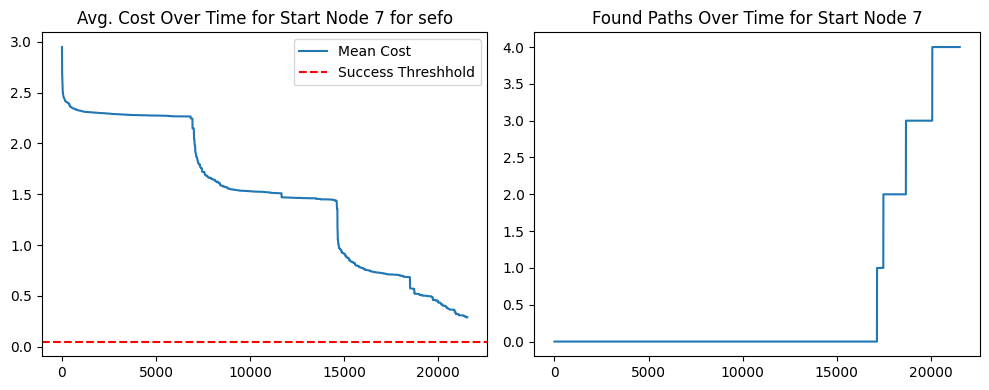

../multirun/2026-02-17/14-59-02/7
Looking at start_idx 8 and end_idx -1 with error threshold 0.05.
Tau action: 0.2; Tau sim: 0.005
Tree Count: 100
Loaded  13693  RRT nodes.


13594it [00:03, 4267.69it/s]


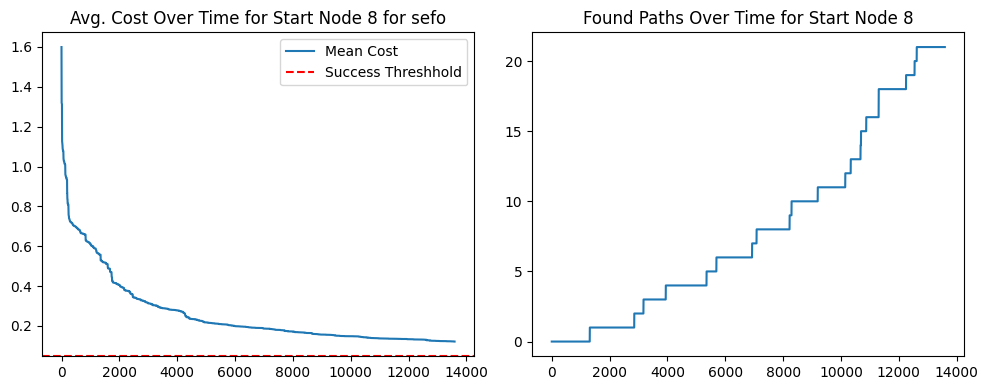

../multirun/2026-02-17/14-59-02/8
Looking at start_idx 9 and end_idx -1 with error threshold 0.05.
Tau action: 0.2; Tau sim: 0.005
Tree Count: 100
Loaded  13253  RRT nodes.


13154it [00:02, 4408.61it/s]


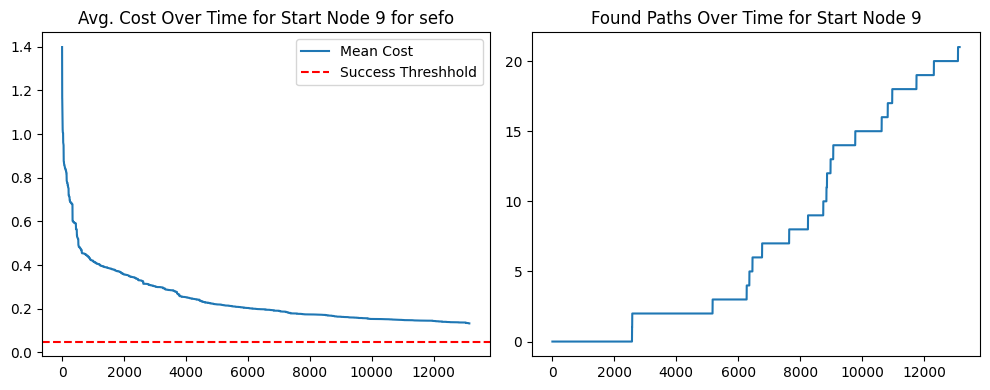

../multirun/2026-02-17/14-59-02/9
Looking at start_idx 10 and end_idx -1 with error threshold 0.05.
Tau action: 0.2; Tau sim: 0.005
Tree Count: 100
Loaded  15321  RRT nodes.


15222it [00:03, 4614.16it/s]


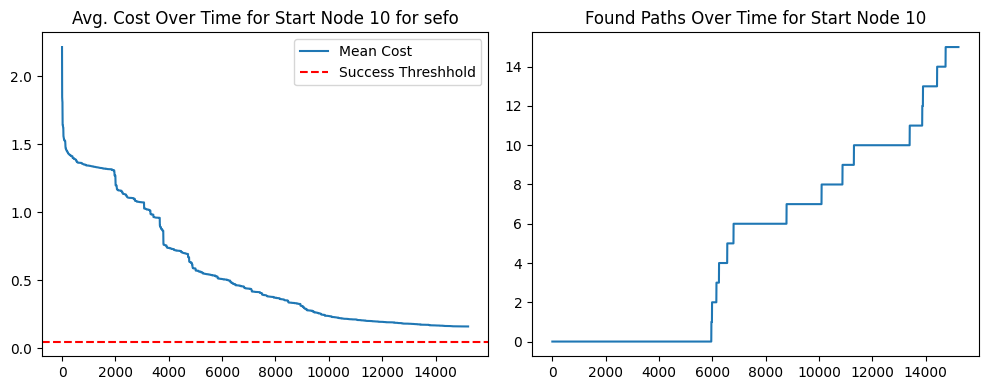

In [ ]:
best_found_paths_count = 0
best_folder_name = ""

for folder_name in range(ds_c):
    dataset = f"{dataset_paths}/{folder_name}"

    print(dataset)

    config_path = os.path.join(dataset, ".hydra/config.yaml")
    cfg = OmegaConf.load(config_path)

    ERROR_THRESH = cfg.RRT.min_cost
    path_diff_thresh = cfg.RRT.path_diff_thresh
    cost_max_method = False

    look_at_specific_start_idx = cfg.RRT.start_idx
    look_at_specific_end_idx = cfg.RRT.end_idx
    cfg.RRT.start_idx = 0
    look_at_specific_end_idx = -1
    # cutoff = 2500
    cutoff = -1

    q_mask = np.array(cfg.RRT.q_mask)
    sim_cfg = cfg.RRT.sim

    mujoco_xml = os.path.join("..", sim_cfg.mujoco_xml)

    print(f"Looking at start_idx {look_at_specific_start_idx} and end_idx {look_at_specific_end_idx} with error threshold {ERROR_THRESH}.")
    print(f"Tau action: {cfg.RRT.sim.tau_action}; Tau sim: {cfg.RRT.sim.tau_sim}")

    tree_dataset = os.path.join(dataset, "trees")
    trees, tree_count, total_nodes_count = load_trees(tree_dataset, cutoff, verbose=1)

    if not q_mask.shape[0]:
        q_mask = np.ones_like(trees[0][0]["state"][1])

    print("Loaded ", total_nodes_count, " RRT nodes.")

    # time_taken = float(np.loadtxt(os.path.join(dataset, "time_taken.txt")))
    # print(f"Time taken to generate tree: {datetime.timedelta(seconds=time_taken)}")

    si = 1 if look_at_specific_start_idx == -1 else look_at_specific_start_idx

    costs_over_time = []
    for i, node in tqdm(enumerate(trees[si])):

        costs = []
        
        for target_idx in range(tree_count):
            # TODO: Cost computation should maybe be the same for all in this case?
            cost = cost_computation(trees[target_idx][0], node, q_mask, cost_max_method)
            if i == 0 or costs_over_time[i-1][target_idx] > cost:
                costs.append(cost)
            else:
                costs.append(costs_over_time[i-1][target_idx])

        costs_over_time.append(costs)

    # Subtract 1 because it also contains a cost against itself
    mean_cost_over_time = [sum(costs)/(len(costs)-1) for costs in costs_over_time]
    found_paths_over_time = [len([1 for c in costs if c < ERROR_THRESH])-1 for costs in costs_over_time]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].set_title(f"Avg. Cost Over Time for Start Node {si} for {cfg.RRT.cost_method}")
    axes[0].plot(mean_cost_over_time, label="Mean Cost")

    if cfg.RRT.end_idx != -1:
        cost_for_target_over_time = [costs[cfg.RRT.end_idx] for costs in costs_over_time]
        axes[0].plot(cost_for_target_over_time, label=f"Target {cfg.RRT.end_idx}")

    axes[0].axhline(y=ERROR_THRESH, color="red", linestyle="--", label="Success Threshhold")
    axes[0].legend()

    axes[1].set_title(f"Found Paths Over Time for Start Node {si}")
    axes[1].plot(found_paths_over_time)

    if best_found_paths_count < found_paths_over_time[-1]:
        best_found_paths_count = found_paths_over_time[-1]
        best_folder_name = dataset

    plt.tight_layout()
    plt.show()

In [8]:
if best_found_paths_count == 0:
    print("No parameters lead to paths being found!")
else:
    print(f"Best results achieved with '{best_folder_name}'! ({best_found_paths_count} of {tree_count} paths found)")

Best results achieved with '../outputs/2026-02-17/14-20-24'! (21 of 100 paths found)
